In [548]:
import pandas as pd
import numpy as np
import requests
import re
import sqlite3 as sql
from bs4 import BeautifulSoup

# Grabs the table from the html page,
# Creating a dataframe from the <table> element
r = requests.get("https://pokemondb.net/pokedex/all")
soup = BeautifulSoup(r.content, "html.parser")\
    .find("table")\
    .prettify()
pokedex = pd.read_html(soup)[0]
pokedex

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,1,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,2,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,3,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,3,Venusaur Mega Venusaur,Grass Poison,625,80,100,123,122,120,80
4,4,Charmander,Fire,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...,...,...
1185,1004,Chi-Yu,Dark Fire,570,55,80,80,135,120,100
1186,1005,Roaring Moon,Dragon Dark,590,105,139,71,55,101,119
1187,1006,Iron Valiant,Fairy Fighting,590,74,130,90,120,60,116
1188,1007,Koraidon,Fighting Dragon,670,100,135,115,85,100,135


In [549]:
# New columns to store specific type information
pokedex['Type1'] = ''
pokedex['Type2'] = ''
# Converts the single type column into type1 and type2 columns
# If pokemon only has one type, then set type2 to None
for index, row in pokedex.iterrows():
    types = row['Type'].split(" ")
    if(len(types) == 1):
        pokedex.at[index, 'Type1'] = types[0]
        pokedex.at[index, 'Type2'] = None
    else:
        pokedex.at[index, 'Type1'] = types[0]
        pokedex.at[index, 'Type2'] = types[2]

# Removes the original single type column from the dataframe
pokedex = pokedex.drop(pokedex.columns[2], axis=1)
# Gets rid of duplicate pokemon that have a regional form or mega evolution
# This is so we can only compare the new pokemon of each generation, and not remakes
# Since this could lead to some confusion during comparisons
pokedex.drop_duplicates(subset='#', keep='first', inplace=True)
pokedex = pokedex.reset_index(drop=True)

pokedex

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type1,Type2
0,1,Bulbasaur,318,45,49,49,65,65,45,Grass,Poison
1,2,Ivysaur,405,60,62,63,80,80,60,Grass,Poison
2,3,Venusaur,525,80,82,83,100,100,80,Grass,Poison
3,4,Charmander,309,39,52,43,60,50,65,Fire,None
4,5,Charmeleon,405,58,64,58,80,65,80,Fire,None
...,...,...,...,...,...,...,...,...,...,...,...
1003,1004,Chi-Yu,570,55,80,80,135,120,100,Dark,Fire
1004,1005,Roaring Moon,590,105,139,71,55,101,119,Dragon,Dark
1005,1006,Iron Valiant,590,74,130,90,120,60,116,Fairy,Fighting
1006,1007,Koraidon,670,100,135,115,85,100,135,Fighting,Dragon


In [550]:
# Adds a generation column indicating which generation the pokemon is from
# There wasn't an easier/more accurate way to do this with online databases,
# so I simply had to manually seperate the pokemon by their generations
generations = []
for i in range(0,1008):
     if(i < 151):
          generations.append(1)
     elif(i < 251):
          generations.append(2)
     elif(i < 386):
          generations.append(3)
     elif(i < 493):
          generations.append(4)
     elif(i < 649):
          generations.append(5)
     elif(i < 721):
          generations.append(6)
     elif(i < 809):
          generations.append(7)
     elif(i < 905):
          generations.append(8)
     else:
          generations.append(9)
pokedex['Generation'] = generations
pokedex

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type1,Type2,Generation
0,1,Bulbasaur,318,45,49,49,65,65,45,Grass,Poison,1
1,2,Ivysaur,405,60,62,63,80,80,60,Grass,Poison,1
2,3,Venusaur,525,80,82,83,100,100,80,Grass,Poison,1
3,4,Charmander,309,39,52,43,60,50,65,Fire,None,1
4,5,Charmeleon,405,58,64,58,80,65,80,Fire,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,1004,Chi-Yu,570,55,80,80,135,120,100,Dark,Fire,9
1004,1005,Roaring Moon,590,105,139,71,55,101,119,Dragon,Dark,9
1005,1006,Iron Valiant,590,74,130,90,120,60,116,Fairy,Fighting,9
1006,1007,Koraidon,670,100,135,115,85,100,135,Fighting,Dragon,9


In [555]:
# Here, we are creating a dataframe for the type matchups in pokemon
r = requests.get("https://pokemondb.net/type")
soup = BeautifulSoup(r.content, "html.parser")\
    .find("table")\
    .prettify()
# Unfilitered dataframe storing our type matchups
type_matchups = pd.read_html(soup)[0]
# Replace all NaN values with 1, for the damage/defense multiplier would be 1
type_matchups = type_matchups.replace('½', 0.5)
type_matchups = type_matchups.replace(np.nan, 1)
# Changes the names of the columns
type_names = ['Normal', 'Fire', 'Water', 'Electric', 'Grass', 'Ice', 'Fighting', 'Poison', 'Ground', 'Flying',\
    'Psychic', 'Bug', 'Rock', 'Ghost', 'Dragon', 'Dark', 'Steel', 'Fairy']
names = ['Attacking Type (Rows) vs Defending Type (Cols)'] + type_names 
type_matchups.set_axis(names, axis=1,inplace=True)
# Converts all multipliers to floats
type_matchups[type_names] = type_matchups[type_names].astype('float64')
type_matchups['Mean Attack Multiplier'] = type_matchups[type_names].mean(axis=1)
# Ranks each type by the mean attack multiplier
type_matchups = type_matchups.sort_values('Mean Attack Multiplier', ascending=False)
type_matchups

/var/folders/t_/fw_ctfbj3pl01ch4zw3zt49r0000gn/T/ipykernel_24960/2729016999.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  type_matchups.set_axis(names, axis=1,inplace=True)


,Attacking Type (Rows) vs Defending Type (Cols),Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy,Mean Attack Multiplier
8,Ground,1.0,2.0,1.0,2.0,0.5,1.0,1.0,2.0,1.0,0.0,1.0,0.5,2.0,1.0,1.0,1.0,2.0,1.0,1.166667
12,Rock,1.0,2.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,2.0,1.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.138889
1,Fire,1.0,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0,1.111111
5,Ice,1.0,0.5,0.5,1.0,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.111111
9,Flying,1.0,1.0,1.0,0.5,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,0.5,1.0,1.083333
6,Fighting,2.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,0.5,0.5,0.5,2.0,0.0,1.0,2.0,2.0,0.5,1.083333
17,Fairy,1.0,0.5,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.5,1.0,1.083333
2,Water,1.0,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0,1.083333
16,Steel,1.0,0.5,0.5,0.5,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.5,2.0,1.055556
13,Ghost,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.027778


In [552]:
# Creates new Attack Multiplier column for each pokemon in our database
pokedex['Attack Multiplier'] = ""
for index, row in pokedex.iterrows():
    # Temp variable to store the pokemon's average attack multiplier
    temp_attack_mult = 0
    # Searches through the Type Matchup dataframe in order to extract the 
    for index1, row1 in type_matchups.iterrows():
        # Searches for the Average Attack Multipliers for both of the pokemon's types
        if(row1['Attacking Type (Rows) vs Defending Type (Cols)'] == row['Type1']):
            temp_attack_mult += type_matchups.at[index1, 'Mean Attack Multiplier']
        if(row1['Attacking Type (Rows) vs Defending Type (Cols)'] == row['Type2']):
            temp_attack_mult += type_matchups.at[index1, 'Mean Attack Multiplier']
    # If pokemon only has one type, return the Attack Multiplier as is
    if(row['Type2'] == None):
        pokedex.at[index, 'Attack Multiplier'] = temp_attack_mult
    # If pokemon has two types, return average of attack multipliers for its two types
    else:
        pokedex.at[index, 'Attack Multiplier'] = temp_attack_mult / 2
pokedex

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type1,Type2,Generation,Attack Multiplier
0,1,Bulbasaur,318,45,49,49,65,65,45,Grass,Poison,1,0.958333
1,2,Ivysaur,405,60,62,63,80,80,60,Grass,Poison,1,0.958333
2,3,Venusaur,525,80,82,83,100,100,80,Grass,Poison,1,0.958333
3,4,Charmander,309,39,52,43,60,50,65,Fire,None,1,1.111111
4,5,Charmeleon,405,58,64,58,80,65,80,Fire,None,1,1.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,1004,Chi-Yu,570,55,80,80,135,120,100,Dark,Fire,9,1.069444
1004,1005,Roaring Moon,590,105,139,71,55,101,119,Dragon,Dark,9,1.0
1005,1006,Iron Valiant,590,74,130,90,120,60,116,Fairy,Fighting,9,1.083333
1006,1007,Koraidon,670,100,135,115,85,100,135,Fighting,Dragon,9,1.027778


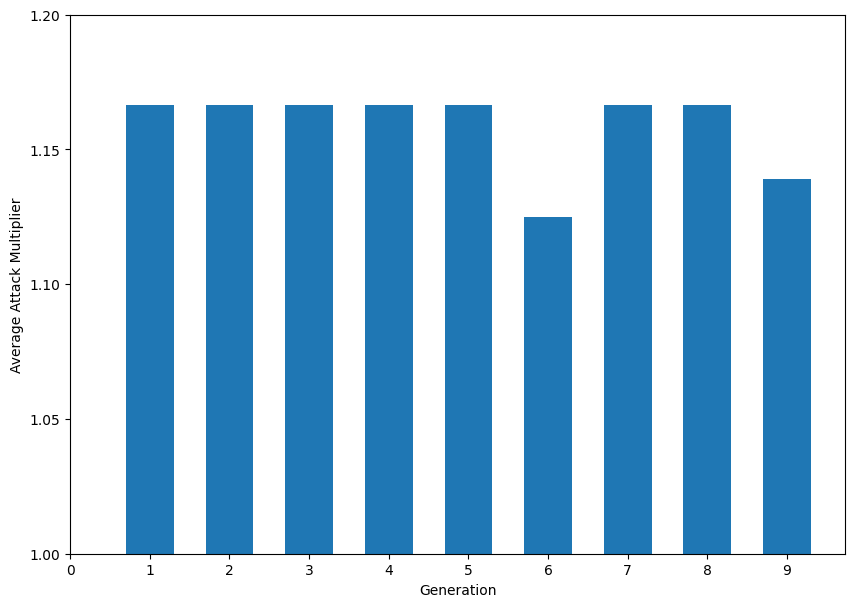

In [553]:
import matplotlib.pyplot as plt
# Pulls dataframe series for each of our axis
gen = pokedex['Generation']
mean_attack = pokedex['Attack Multiplier']
# Creates a reasonably size bar plot of the mean attack multiplier for each generation
fig = plt.figure(figsize =(10, 7))
plt.bar(gen, mean_attack, width = 0.6)
plt.xlabel('Generation')
plt.ylabel('Average Attack Multiplier')
# Plot utility to give us a scoped in look of the difference between the averages of each generation
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.yticks([1.0, 1.05, 1.1, 1.15, 1.2])
plt.ylim([1.0, 1.2])
plt.show()

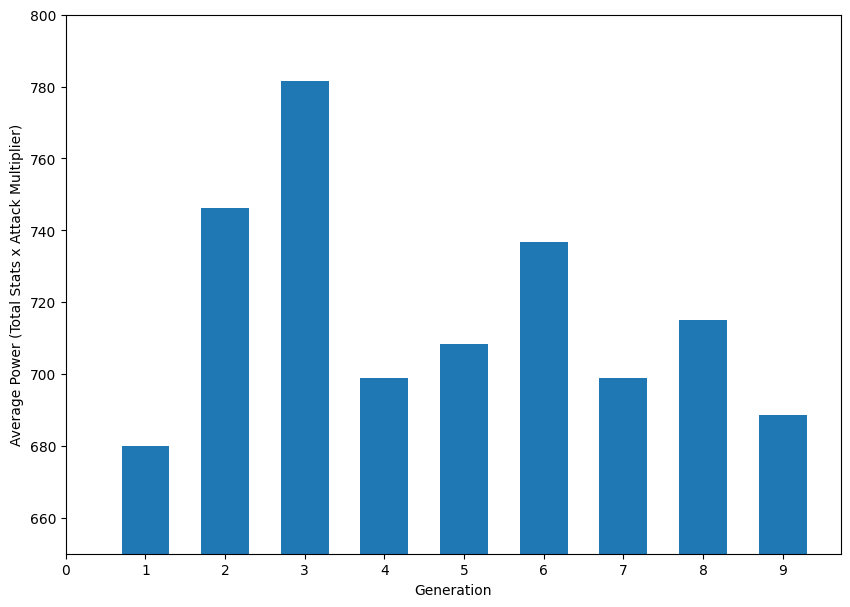

In [556]:
# Creates graph of pokemon's power(total stats * attack multiplier)
pokedex['Power'] = ""
for index, row in pokedex.iterrows():
    pokedex.at[index, 'Power'] = pokedex.at[index, 'Attack Multiplier'] * pokedex.at[index, 'Total']
# Pulls dataframe series for each of our axis
gen = pokedex['Generation']
mean_power = pokedex['Power']
# Creates a reasonably size bar plot of the mean attack multiplier for each generation
fig = plt.figure(figsize =(10, 7))
plt.bar(gen, mean_power, width = 0.6)
plt.xlabel('Generation')
plt.ylabel('Average Power (Total Stats x Attack Multiplier)')
# Plot utility to give us a scoped in look of the difference between the averages of each generation
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.ylim([650, 800])
plt.show()